In [1]:
    import fiona
    import os,os.path
    from shapely.geometry import shape,mapping
    from shapely.ops import transform
    from functools import partial
    import pyproj
    from fiona.crs import from_epsg
    import osmnx as ox
    import matplotlib.pyplot as plt
    import geopandas as gpd

    %matplotlib inline

In [2]:
def createPoints(root_Dir, inshp , outshp, mini_dist):
    
    '''
    This function will parse through the street network of provided city and
    clean all highways and create points every mini_dist meters (or as specified) along
    the linestrings
    Required modules: Fiona and Shapely

    parameters:
        inshp: the input linear shapefile, must be in WGS84 projection, ESPG: 4326
        output: the result point feature class
        mini_dist: the minimum distance between two created point

    last modified by Xiaojiang Li, MIT Senseable City Lab
    
    '''
    inshp = root_Dir + inshp
    outshp = root_Dir + outshp
    input_crs = ''
    count = 0
    s = {'trunk_link','tertiary','motorway','motorway_link','steps', None, ' ','pedestrian','primary', 'primary_link','footway','tertiary_link', 'trunk','secondary','secondary_link','tertiary_link','bridleway','service'}
    
    # the temporaray file of the cleaned data
    root = os.path.dirname(root_Dir)
    basename = 'clean_' + os.path.basename(inshp)
    temp_cleanedStreetmap = os.path.join(root,basename)
    c = fiona.open(inshp)
    input_crs = c.crs['init']
    c.close()
    # if the tempfile exist then delete it
    if os.path.exists(temp_cleanedStreetmap):
        fiona.remove(temp_cleanedStreetmap, 'ESRI Shapefile')
    
    # clean the original street maps by removing highways, if it the street map not from Open street data, users'd better to clean the data themselve
    with fiona.open(inshp) as source, fiona.open(temp_cleanedStreetmap, 'w', driver=source.driver, crs=source.crs,schema=source.schema) as dest:
        for feat in source:
            try:
                i = feat['properties']['highway'] # for the OSM street data
                if i in s:
                    continue
            except:
                # if the street map is not osm, do nothing. You'd better to clean the street map, if you don't want to map the GVI for highways
                key = dest.schema['properties'].keys()[0] # get the field of the input shapefile and duplicate the input feature
                i = feat['properties'][key]
                if i in s:
                    continue
            
            dest.write(feat)

    schema = {
        'geometry': 'Point',
        'properties': {'id': 'int'},
    }

    # Create pointS along the streets
    with fiona.drivers():
        #with fiona.open(outshp, 'w', 'ESRI Shapefile', crs=source.crs, schema) as output:
        with fiona.open(outshp, 'w', crs = from_epsg(4326), driver = 'ESRI Shapefile', schema = schema) as output:
            for line in fiona.open(temp_cleanedStreetmap):
                first = shape(line['geometry'])
                
                length = first.length
                
                try:
                    # convert degree to meter, in order to split by distance in meter
                    project = partial(pyproj.transform,pyproj.Proj(init=input_crs),pyproj.Proj(init='EPSG:3857')) #3857 is psudo WGS84 the unit is meter
                    
                    line2 = transform(project, first)
                    linestr = list(line2.coords)
                    dist = mini_dist #set
                    for distance in range(0,int(line2.length), dist):
                        point = line2.interpolate(distance)
                        
                        # convert the local projection back the the WGS84 and write to the output shp
                        project2 = partial(pyproj.transform,pyproj.Proj(init='EPSG:3857'),pyproj.Proj(init='EPSG:4326'))
                        point = transform(project2, point)
                        output.write({'geometry':mapping(point),'properties': {'id':1}})
                except:
                    print ("You should make sure the input shapefile is WGS84")
                    return
                    
    print("Process Complete")
    
    # delete the temprary cleaned shapefile
    fiona.remove(temp_cleanedStreetmap, 'ESRI Shapefile')


In [3]:
place_name = "Birmingham"

In [4]:
graph = ox.graph_from_place(place_name,network_type='drive')

In [5]:
# buildings = ox.buildings_from_place(place_name)

In [6]:
nodes, edges = ox.graph_to_gdfs(graph)

/work/sagarj/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:1298: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/work/sagarj/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:1303: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


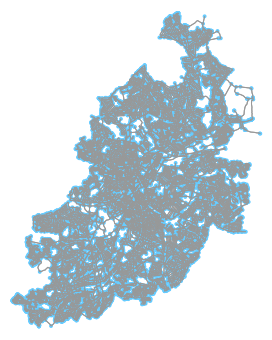

ValueError: max() arg is an empty sequence

In [7]:
fig, ax = ox.plot_graph(graph)
plt.tight_layout()

In [85]:
G_projected = ox.project_graph(graph)

In [86]:
# G_projected

In [87]:
ox.save_graph_shapefile(G_projected, filename='../Data/'+place_name)

In [88]:
roads = gpd.read_file('Data/'+place_name+'/edges/edges.shp')

In [90]:
c = fiona.open('Data/'+place_name+'/edges/edges.shp')
crs = c.crs
print crs

{'init': u'epsg:32630'}


In [92]:
root = 'Data/'+place_name+'/edges/'
createPoints(root , 'edges.shp', 'samples.shp',200)

Process Complete


In [93]:
points_samples = gpd.read_file('Data/'+place_name+'/edges/samples.shp')

In [94]:
points_samples.head()

,id,geometry
0,1,POINT (-1.91159 52.40826)
1,1,POINT (-1.91278 52.40899)
2,1,POINT (-1.91085 52.40891)
3,1,POINT (-1.80940 52.51095)
4,1,POINT (-1.90161 52.47380)


In [35]:
len(roads)

161911

In [36]:
roads.head()

,access,area,bridge,est_width,from,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,to,tunnel,width,geometry
0,None,None,None,None,370068561,residential,None,0,None,17.609,20 mph,Epstein Road,False,10780443,None,None,95944704,None,None,"LINESTRING (715931.281 5710314.614, 715917.030..."
1,None,None,None,None,95944707,residential,None,0,None,68.247,20 mph,Galsworthy Close,False,10780432,None,None,95944704,None,None,"LINESTRING (715964.413 5710256.225, 715934.225..."
2,None,None,None,None,95944671,residential,None,0,None,41.109,20 mph,Epstein Road,False,10780443,None,None,95944704,None,None,"LINESTRING (715885.341 5710277.855, 715917.030..."
3,None,None,None,None,277489,residential,None,0,None,29.564,30 mph,Woodside Grove,False,3398626,None,None,193724417,None,None,"LINESTRING (695323.706 5722787.895, 695294.102..."
4,None,None,None,None,277490,residential,None,0,None,80.433,30 mph,Woodside Grove,False,3398626,None,None,193724417,None,None,"LINESTRING (695216.776 5722810.611, 695286.927..."


In [ ]:
GSVpanoMgeoetadataCollector(inputShp,1000,outputTxt)